In [2]:
from dotenv import load_dotenv
import os

load_dotenv()

os.environ['GROQ_API_KEY'] = os.getenv('GROQ_API_KEY')
os.environ['LANGCHAIN_API_KEY'] = os.getenv('LANGCHAIN_API_KEY')
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ['LANGCHAIN_PROJECT'] = "BuffetBot"
os.environ['GOOGLE_API_KEY'] = os.getenv('GOOGLE_API_KEY')
os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")

#### Tools

In [3]:
import ssl
from urllib.request import urlopen
import certifi
import json
from langchain_core.tools import tool
from typing import List, Optional, TypedDict, Annotated

# Function to clean the ticker input
def clean_ticker(ticker: str) -> str:
    return ticker.strip().upper()

# Function 1
@tool
def get_financial_key_metrics(ticker: str) -> str:
    """
    Retrieve all financial key metrics for a specified company.

    This function fetches financial data from the Financial Modeling Prep API
    and returns all the data as a formatted string.

    Parameters:
    ticker (str): The stock symbol of the company (e.g., "AAPL" for Apple Inc.).

    Returns:
    str: A formatted string containing all key metrics for the company.
    """
    ticker = clean_ticker(ticker)
    api_key = os.getenv('FINANCIAL_MODELING_PREP_API_KEY')
    url = f"https://financialmodelingprep.com/api/v3/key-metrics/{ticker}?apikey={api_key}"
    
    context = ssl.create_default_context(cafile=certifi.where())
    
    with urlopen(url, context=context) as response:
        data = response.read().decode("utf-8")
    
    json_data = json.loads(data)
    
    result = ""
    for item in json_data:
        result += "========================\n"
        for key, value in item.items():
            result += f"{key}: {value}\n"
    
    return result

# Function 2
@tool
def get_financial_ratios(ticker: str) -> str:
    """
    Retrieve all financial ratios for a specified company.

    This function fetches financial ratio data from the Financial Modeling Prep API
    and returns all the data as a formatted string.

    Parameters:
    ticker (str): The stock symbol of the company (e.g., "AAPL" for Apple Inc.).

    Returns:
    str: A formatted string containing all financial ratios for the company.
    """
    ticker = clean_ticker(ticker)
    api_key = os.getenv('FINANCIAL_MODELING_PREP_API_KEY')
    url = f"https://financialmodelingprep.com/api/v3/ratios/{ticker}?&apikey={api_key}"
    
    context = ssl.create_default_context(cafile=certifi.where())
    
    with urlopen(url, context=context) as response:
        data = response.read().decode("utf-8")
    
    json_data = json.loads(data)
    
    result = ""
    for item in json_data:
        result += "========================\n"
        for key, value in item.items():
            result += f"{key}: {value}\n"
    
    return result

# Function 3
# Will add more functions as needed

tools = [get_financial_key_metrics, get_financial_ratios]

#### State

In [4]:
#State
from langgraph.graph.message import AnyMessage, add_messages
from langchain_core.documents import Document

class State(TypedDict):
    messages: Annotated[List[AnyMessage], add_messages]
    tickers: Optional[List[str]]
    financial_summary: Optional[str]
    summarized_docs: Optional[str]
    routing_decision: Optional[str]  # Add this line

#### Router

In [5]:
from typing import Literal
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_openai import ChatOpenAI

# Data model
class RouteQuery(BaseModel):
    """Route a user query to the appropriate action."""

    action: Literal["company_specific", "general_knowledge"] = Field(
        ...,
        description="Given a user question, choose whether it's company-specific or general knowledge.",
    )

# LLM with function call
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)
structured_llm_router = llm.with_structured_output(RouteQuery)

# Prompt
system = """You are an expert at determining whether a query is about a specific company or financial data, or if it's a general knowledge question.
For queries about specific companies, financial metrics, stock performance, or company-specific data, use 'company_specific'.
For general knowledge questions, including explanations of financial concepts not tied to a specific company, use 'general_knowledge'."""

route_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "{question}"),
    ]
)

question_router = route_prompt | structured_llm_router

def router(state: State) -> State:
    last_message = state["messages"][-1].content if state["messages"] else ""
    result = question_router.invoke({"question": last_message})
    
    # Update the state with the routing decision
    state['routing_decision'] = result.action
    
    return state

##### Test the router function 

In [72]:
# Test the router function

# Sample queries
test_queries = [
    "What are Apple's financial ratios?",
    "How do I calculate return on investment?",
    "Can you explain Tesla's recent stock performance?",
    "What is the difference between stocks and bonds?",
    "What was Amazon's revenue last quarter?",
    "What factors affect a company's price-to-earnings ratio?",
    "How has the tech sector performed over the last year?",
]


# Run tests
for query in test_queries:
    mock_state = create_mock_state(query)
    result = router(mock_state)
    print(f"Query: {query}")
    print(f"Decision: {result}")
    print("---")

Query: What are Apple's financial ratios?
Decision: company_specific
---
Query: How do I calculate return on investment?
Decision: general_knowledge
---
Query: Can you explain Tesla's recent stock performance?
Decision: company_specific
---
Query: What is the difference between stocks and bonds?
Decision: general_knowledge
---
Query: What was Amazon's revenue last quarter?
Decision: company_specific
---
Query: What factors affect a company's price-to-earnings ratio?
Decision: general_knowledge
---
Query: How has the tech sector performed over the last year?
Decision: general_knowledge
---


#### Knowledge Base Retriever

In [23]:
from langchain_openai import OpenAIEmbeddings
from langchain_community.vectorstores import FAISS
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough
from langchain.prompts import ChatPromptTemplate


embeddings = OpenAIEmbeddings()

vector_store = FAISS.load_local(
    "knowledge_base", embeddings, allow_dangerous_deserialization=True
)
retriever = vector_store.as_retriever(search_type="mmr", search_kwargs={"k": 5})

#------------------------------
# Prompt for Generating Answer from HyDE. Keep {context} and {question} to not break it.
template = """Answer the following question based on this context:

{context}

Question: {question}
"""
#------------------------------

universal_prompt = ChatPromptTemplate.from_template(template)

# HyDE

#------------------------------
# Prompt for generating HyDE paragraph
template = """You are Warren Buffet. Answer this question with a passage using your principles: {question}
Passage:"""
#------------------------------


prompt_hyde = ChatPromptTemplate.from_template(template)

from langchain_core.output_parsers import StrOutputParser
from langchain_openai import ChatOpenAI

# Generate hypothetical document
generate_hyde_passage = (
    prompt_hyde | ChatOpenAI(temperature=0) | StrOutputParser()
)

# Retrieve documents based on the generated passage
hyde_retriever = generate_hyde_passage | retriever

def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

# Complete HyDE RAG chain
hyde_rag_chain = (
    {"question": RunnablePassthrough()}
    | {"hyde_passage": generate_hyde_passage, "question": RunnablePassthrough()}
    | {"context": hyde_retriever | format_docs, "question": lambda x: x["question"]}
    | universal_prompt
    | ChatOpenAI(temperature=0)
)

# Example usage
# result = hyde_rag_chain.invoke({"question": "What are the key principles of value investing?"})
# print(result)

def retrieve_docs(state: State) -> State:
    last_message = state["messages"][-1].content if state["messages"] else ""
    retrieved_docs = hyde_rag_chain.invoke({"question": last_message})
    
    # Create a ChatPromptTemplate for summarization
    summarization_template = """Given the following information and the user's question, provide a 400 word summary that is relevant to answering the question, refer to the context:

    User's question: {question}

    Information:
    {docs}

    Relevant summary:"""
    summarization_prompt = ChatPromptTemplate.from_template(summarization_template)
    
    # Create the summarization chain
    summarization_chain = (
        summarization_prompt 
        | ChatOpenAI(temperature=0) 
        | StrOutputParser()
    )
    
    # Invoke the summarization chain
    summary = summarization_chain.invoke({"docs": retrieved_docs, "question": last_message})
    
    state['summarized_docs'] = summary
    return state

##### Test RAG Fusion

In [11]:
# Test the retrieve_docs function

from langchain.schema import HumanMessage

# Create a test state
test_query = "What is the difference between stocks and bonds?"
test_state = State(
    messages=[HumanMessage(content=test_query)],
    tickers=None,
    financial_summary=None,
    summarized_docs=None,
    routing_decision=None
)

# Call the retrieve_docs function
result_state = retrieve_docs(test_state)

print("Original query:", test_query)
print("\nSummarized docs:")
print(result_state['summarized_docs'])

Original query: What is the difference between stocks and bonds?

Summarized docs:
Stocks represent ownership in a company, while bonds represent a loan to a company or government. Stocks offer higher returns but come with higher risk due to value fluctuations, while bonds provide stability and predictable income through interest payments with lower returns.


#### Ticker Extractor

In [14]:
from typing import List, Optional
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_openai import ChatOpenAI

# Data model for ticker extraction
class TickerExtraction(BaseModel):
    """Extract the relevant stock tickers from a user query."""

    tickers: List[str] = Field(
        default_factory=list,
        description="The stock tickers mentioned or implied in the query. Use an empty list if no specific companies are mentioned.",
    )

# LLM with function call
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)
structured_llm_ticker_extractor = llm.with_structured_output(TickerExtraction)

# Prompt
system = """You are an expert at identifying company stock tickers in financial queries.
If specific companies are mentioned or strongly implied, provide their stock tickers as a list.
If no specific companies are mentioned or implied, return an empty list.
Always provide a brief explanation for your decision."""

ticker_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "{question}"),
    ]
)

ticker_extractor = ticker_prompt | structured_llm_ticker_extractor

def extract_ticker(state: State) -> State:
    last_message = state["messages"][-1].content if state["messages"] else ""
    result = ticker_extractor.invoke({"question": last_message})
    
    state['tickers'] = result.tickers
    
    return state

In [55]:
# Test the ticker extractor

# Sample queries
test_queries = [
    "What are Apple's financial ratios?",
    "How do I calculate return on investment?",
    "Can you explain Tesla's recent stock performance?",
    "Compare Microsoft and Google's profit margins",
    "What's the latest news on Amazon?",
]

# Create a mock state for testing
def create_mock_state(query):
    return {
        "messages": [{"role": "human", "content": query}],
        "tickers": [],
        "observations": None,
        "company_summary": None,
        "chunked_docs": None
    }

# Run tests
for query in test_queries:
    initial_state = create_mock_state(query)
    updated_state = extract_ticker(initial_state)
    print(f"Query: {query}")
    print(f"Initial State Tickers: {initial_state['tickers']}")
    print(f"Updated State Tickers: {updated_state['tickers']}")
    print("---")

Query: What are Apple's financial ratios?
Initial State Tickers: []
Updated State Tickers: ['AAPL']
---
Query: How do I calculate return on investment?
Initial State Tickers: []
Updated State Tickers: []
---
Query: Can you explain Tesla's recent stock performance?
Initial State Tickers: []
Updated State Tickers: ['TSLA']
---
Query: Compare Microsoft and Google's profit margins
Initial State Tickers: []
Updated State Tickers: ['MSFT', 'GOOGL']
---
Query: What's the latest news on Amazon?
Initial State Tickers: []
Updated State Tickers: ['AMZN']
---


#### API Agent

In [28]:
from langchain.agents import AgentExecutor, create_react_agent
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI

model = ChatOpenAI(model="gpt-4o-mini", temperature=0)
prompt = ChatPromptTemplate.from_template("""
You are a financial analysis assistant powered by Warren Buffett's investment philosophy. Your job is to gather data relevant to the question as best as you can and prepare a good summary.
You have access to the following tools:

{tools}

Use the following format:

Question: The question you must provide relevant information on.
Ticker: The company you should research

Thought: Reflect on what information you need to answer the question and which tool should provide you with the best information. 

Action: Choose one of [{tool_names}]
Action Input: The input to the tool call. This must be ONLY the ticker symbol, with no additional characters, spaces, or formatting. For example: AAPL

Observation: The result of the action
... (this Thought/Action/Action Input/Observation can be repeated as necessary)

Thought: I now have sufficient information to provide a comprehensive summary

Final Answer: Provide a detailed summary of the relevant financial metrics/ratios and their significance in answering the question, incorporating Warren Buffett's investment principles where applicable.

Begin your analysis:

Question: {input}
Ticker: {ticker}
Thought:{agent_scratchpad}""")

agent = create_react_agent(model, tools, prompt)
agent_executor = AgentExecutor(agent=agent, tools=tools, verbose=True)

def execute_financial_analysis(state: State) -> State:
    last_message = state['messages'][-1].content
    tickers = state['tickers']
    
    result = agent_executor.invoke(
        {
            "input": last_message,
            "ticker": tickers
        }
    )
    
    state['financial_summary'] = result['output']
 
    return state

In [62]:
# Test execute_financial_analysis function
test_state = {
    'messages': [{'content': 'What is the current P/E ratio and debt-to-equity ratio for Apple?'}],
    'tickers': 'AAPL'
}

result_state = execute_financial_analysis(test_state)

print("Financial Summary:")
print(result_state['financial_summary'])




> Entering new AgentExecutor chain...
To answer the question regarding the current P/E ratio and debt-to-equity ratio for Apple, I need to gather the relevant financial metrics that include these specific ratios. The best tool for this purpose is `get_financial_key_metrics`, as it will provide the necessary key financial metrics, including the P/E ratio and debt-to-equity ratio.

Action: get_financial_key_metrics  
Action Input: AAPL  
[{'symbol': 'AAPL', 'date': '2023-09-30', 'operatingCashFlowPerShare': 7.021174930677783, 'interestCoverageRatio': 29.062039155860667, 'workingCapital': -1742000000, 'daysSalesOutstanding': 58.07564866874519, 'bookValuePerShare': 3.947223589389663, 'dividendYield': 0.005573960673721321, 'currentRatio': 0.9880116717592975, 'payablesTurnover': 3.420117870661705}, {'symbol': 'AAPL', 'date': '2022-09-24', 'operatingCashFlowPerShare': 7.532762624088375, 'interestCoverageRatio': 40.74957352439441, 'workingCapital': -18577000000, 'daysSalesOutstanding': 56.40

#### Buffet Agent

In [32]:
# Buffet Agent
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser

llm = ChatOpenAI(model="gpt-4o-mini")

def buffet_agent(state: State) -> State:
    messages = state['messages']
    summarized_docs = state.get("summarized_docs")
    financial_summary = state.get('financial_summary', '') if 'financial_summary' in state else ''

    # Construct the prompt
    template = f"""
    You are Warren Buffett, the legendary investor known for your value investing approach and long-term perspective. 
    You are currently having a conversation with a user, here's what has been said so far:

    Message History:
    {' '.join([m.content for m in messages[:-1]])}

    At this moment you need to answer this question from the user.
    Question: {messages[-1].content}

    In order to properly answer the question you will rely on a financial analysis summary and an investment philosophy summary.
    These have been tailored to the question and will help you with specific details you will need. Make sure to use them in your answer.
    Financial Analysis:
    {financial_summary}

    Buffet's Investment Philosophy:
    {summarized_docs}

    Based on this financial analysis and your investment philosophy, provide your thoughts and advice on the question
    """
    prompt = ChatPromptTemplate.from_template(template)

    buffetbot = prompt | llm | StrOutputParser()
    response = buffetbot.invoke({"messages": messages, "summarized_docs": summarized_docs, "financial_summary": financial_summary})

    # Append the response to the state as a new message
    state['messages'].append({
        'role': 'assistant',
        'content': response
    })

    return state


In [22]:
# Test buffet_agent with different inputs

# Sample summarized_docs
sample_summarized_docs = """
Focus on companies with strong fundamentals and a competitive advantage.
Invest for the long term and ignore short-term market fluctuations.
Look for businesses with consistent earnings and high return on equity.
Prioritize management quality and integrity when evaluating companies.
"""

# Sample financial summary
sample_financial_summary = """
Company XYZ:
- Revenue: $1.5 billion (up 10% YoY)
- Net Income: $300 million (up 15% YoY)
- P/E Ratio: 18.5
- Debt-to-Equity Ratio: 0.4
- Return on Equity: 22%
"""

# Test cases
test_cases = [
    {
        "messages": [
            {"role": "human", "content": "What do you think about investing in tech stocks?"}
        ],
        "summarized_docs": sample_summarized_docs,
        "financial_summary": None
    },
    {
        "messages": [
            {"role": "human", "content": "Should I invest in Company XYZ?"}
        ],
        "summarized_docs": sample_summarized_docs,
        "financial_summary": sample_financial_summary
    },
    {
        "messages": [
            {"role": "human", "content": "How important is dividend yield in your investment strategy?"}
        ],
        "summarized_docs": sample_summarized_docs,
        "financial_summary": None
    }
]

# Run tests
for i, test_case in enumerate(test_cases, 1):
    print(f"\nTest Case {i}:")
    state = {
        "messages": test_case["messages"],
        "summarized_docs": test_case["summarized_docs"],
        "financial_summary": test_case["financial_summary"]
    }
    
    result_state = buffet_agent(state)
    
    print(f"Question: {test_case['messages'][-1]['content']}")
    print(f"Summarized Docs: {test_case['summarized_docs']} " )
    print(f"Financial Summary Used: {'Yes' if test_case['financial_summary'] else 'No'}")
    print("-" * 50)



Test Case 1:
Question: Investing in tech stocks can be a compelling opportunity, but it requires careful consideration of the underlying fundamentals. My investment philosophy emphasizes focusing on companies with strong fundamentals and a competitive advantage. In the tech sector, this can manifest as having a unique product, a robust market position, or proprietary technology that sets a company apart from its competitors.

When evaluating tech stocks, it's essential to look for businesses with consistent earnings and high return on equity. Many tech companies experience significant volatility in their earnings, especially those that are still in the growth phase or heavily investing in research and development. Therefore, I advise looking for established tech companies that have demonstrated a track record of profitability and a solid business model.

Moreover, management quality and integrity are paramount. In the fast-paced tech world, companies can pivot quickly, and having a tr

#### Graph

In [33]:

# Graph
from langgraph.graph import StateGraph, END, START
from langchain_core.messages import HumanMessage
graph = StateGraph(State)

graph.add_node("Router", router)
graph.add_node("DocRetriever", retrieve_docs)
graph.add_node("TickerExtractor", extract_ticker)
graph.add_node("FinancialAnalyst", execute_financial_analysis)
graph.add_node("BuffetAgent", buffet_agent)

graph.add_edge(START, "Router")
graph.add_conditional_edges(
    "Router",
    lambda x: x['routing_decision'],
    {
        "general_knowledge": "DocRetriever",
        "company_specific": "TickerExtractor"
    }
)

graph.add_edge("DocRetriever", "BuffetAgent")
graph.add_edge("TickerExtractor", "FinancialAnalyst")
graph.add_edge("FinancialAnalyst", "DocRetriever")
graph.add_edge("BuffetAgent", END)

multi_agent_graph = graph.compile()


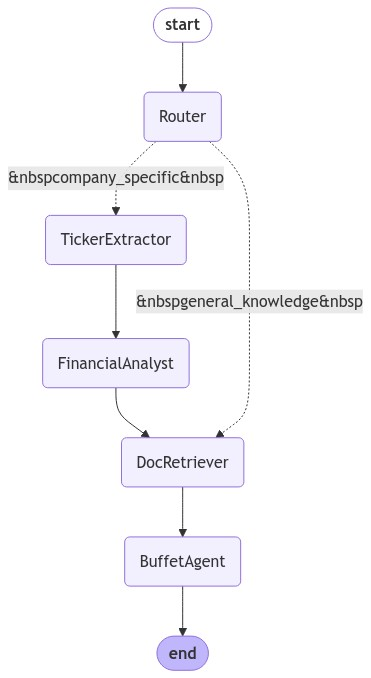

In [26]:
from IPython.display import Image, display

display(Image(multi_agent_graph.get_graph(xray=True).draw_mermaid_png()))

In [34]:
# Initialize the state with a message
initial_state = State(
    messages=[HumanMessage(content="What is the current P/E ratio for Apple?")],
    tickers=None,
    financial_summary=None,
    chunked_docs=None,
    routing_decision=None
)

# Run the graph with the initial state
for s in multi_agent_graph.stream(initial_state):
    if "__end__" not in s:
        print(s)
        print("---")


{'Router': {'messages': [HumanMessage(content='What is the current P/E ratio for Apple?', id='2839b92f-6a46-4942-8691-0446fb20d4a2')], 'tickers': None, 'financial_summary': None, 'summarized_docs': None, 'routing_decision': 'company_specific'}}
---
{'TickerExtractor': {'messages': [HumanMessage(content='What is the current P/E ratio for Apple?', id='2839b92f-6a46-4942-8691-0446fb20d4a2')], 'tickers': ['AAPL'], 'financial_summary': None, 'summarized_docs': None, 'routing_decision': 'company_specific'}}
---


> Entering new AgentExecutor chain...
To determine the current P/E (Price-to-Earnings) ratio for Apple Inc. (AAPL), I need to gather financial ratio data, as the P/E ratio is a key financial metric that reflects the company's valuation relative to its earnings. The best tool to provide this information is the one that retrieves financial ratios.

Action: get_financial_ratios  
Action Input: AAPL
symbol: AAPL
date: 2023-09-30
calendarYear: 2023
period: FY
currentRatio: 0.988011671759